# Chapter 04 - Training Models

## Linear Regression

In [15]:
# generate the data
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

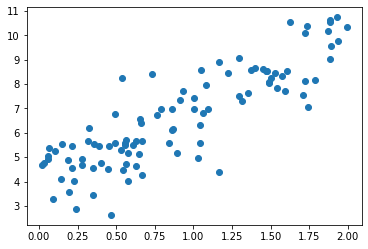

In [16]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.show()

### Performing linear regressing with the closed solution

In [17]:
X_b = np.c_[np.ones((100, 1)), X] # add X_0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [18]:
theta_best

array([[3.95044807],
       [2.95778419]])

This is our best parameters to fit the data. Let's make a prediction with them:

In [21]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.95044807],
       [9.86601645]])

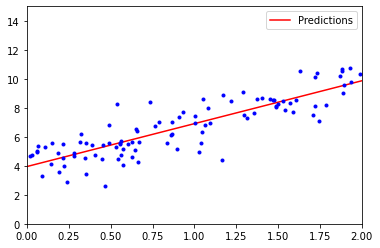

In [28]:
plt.plot(X_new, y_predict, "r-", label = "Predictions")
plt.legend()
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

### Performing linear regression using Scikit-Learn

In [30]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.95044807]), array([[2.95778419]]))

In [31]:
lin_reg.predict(X_new)

array([[3.95044807],
       [9.86601645]])

### Computational Complexity

Training a linear regression model using the normal equation can be hard for a machine depending on the approach you take. The computation complexity of inverting such a matrix is tipically about $O(n^{2.4})$ to $O(n^{3})$. 

The approach taken by Scikit-Learn, which consists in the Singular Value Decomposition (SVD) is much faster, about $O(n^2)$. However, both approaches get very slow when the number of features grow, even though, they scale nicely when it comes to the number of instances.

A better approach to the case when we have many features is shown next.

## Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Since the purpose here is not to enter deeply into the mathematical aspects we won't dive into the partial derivates world.

Fortunately, the MSE cost function for a Linear Regression model happens to be a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly.

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Next figure shows Gradient Descent on a training set where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).

![precision_recall_tradeoff](./images/ch04_linear_regression_cost_function.png)

As you can see, on the left the Gradient Descent algorithm goes straight toward the minimum, thereby reaching it quickly, whereas on the right it first goes in a direction almost orthogonal to the direction of the global minimum, and it ends with a long march down an almost flat valley. It will eventually reach the minimum, but it will take a long time.

That's why, when using the GD, you should ensure that all features have similar scale.

### Batch Gradient Descent

There are some strategies when implementing the GD. One of them is the batch gradient descent. Which consists of inputting the whole training  data into the model at once, such that we can calculate the partial derivatives all at one, meaning that to perform each update of the parameters we need to consume the whole dataset.

In [37]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients 

In [38]:
theta

array([[3.95044807],
       [2.95778419]])

Which is exactly what is found out from other solutions.

### Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.

Besides, the stochasticity nature of SGD makes it possible to escape local minima points, helping the algorithm converging to the global minima. However, since it is stochastic, the algorithm will not settle down the global minima for too long. It will bounce around it. Nevertheless, we can implement a learning schedule to reduce the learning rate such that the algorithm will eventually stop bouncing around the global minima, if it reaches it. 

In [39]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
    

In [40]:
theta

array([[3.94558612],
       [2.90191957]])

Note that the GD descent iterated 1000 times over the whole training set, whereas SGD goes through it only 50 times and still reaches a good solution.

We can also use SGD with Scikit-Learn:

In [41]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [42]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.88392167]), array([2.90276167]))

### Mini-batch Gradient Descent

The last Gradient Descent algorithm we will look at is called Mini-batch Gradient Descent. It is simple to understand once you know Batch and Stochastic Gradient Descent: at each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.